In [1]:
import pkg_resources
from pyforest import *
import datetime, pickle, copy
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)
import matplotlib.pyplot as plt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import quandl
plt.style.use('ggplot')
from statistics import variance 
from random import randint
import scipy as sp
from scipy import stats

import ffn
from matplotlib import cm
import numpy as np

from sklearn.preprocessing import scale # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, r2_score
import sklearn.mixture as mix
import math, pickle
from math import sqrt
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV, cross_validate
import warnings

import seaborn as sns
sns.set()
from hmmlearn.hmm import GaussianHMM
from random import randint
from sklearn import mixture
import itertools
from scipy import linalg
import matplotlib as mpl
warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:
import yfinance as yf
df = yf.download('DOGE-USD', start='2021-08-17')

print(f'DOGECOIN:')
print(df.head())
print('\n')
print(df.shape)

[*********************100%%**********************]  1 of 1 completed

DOGECOIN:
                Open      High       Low     Close  Adj Close      Volume
Date                                                                     
2021-08-17  0.319631  0.339462  0.295763  0.299442   0.299442  5699700481
2021-08-18  0.299203  0.324227  0.282016  0.303739   0.303739  6347995770
2021-08-19  0.303376  0.319018  0.294088  0.317144   0.317144  3760495939
2021-08-20  0.317571  0.333223  0.314142  0.327491   0.327491  3512291078
2021-08-21  0.327395  0.329356  0.315433  0.316797   0.316797  2600396651


(1101, 6)


In [22]:
data = df[['High','Low','Open','Adj Close', 'Volume']]
data['returns'] = np.log(data['Adj Close'] / data['Adj Close'].shift())
data.dropna(inplace=True)
data.tail()

,High,Low,Open,Adj Close,Volume,returns
Date,,,,,,
2024-08-17,0.103631,0.100156,0.100439,0.102755,305545333,0.022797
2024-08-18,0.104306,0.100169,0.102755,0.100172,377630490,-0.025459
2024-08-19,0.101807,0.098712,0.100172,0.101504,463249309,0.013209
2024-08-20,0.105619,0.101229,0.101506,0.103001,695089222,0.014640
2024-08-22,0.106312,0.104286,0.106159,0.105292,521046976,0.021999


count    1100.000000
mean        0.113739
std         0.058050
min         0.053012
25%         0.071535
50%         0.086498
75%         0.143374
max         0.327491
Name: Adj Close, dtype: float64

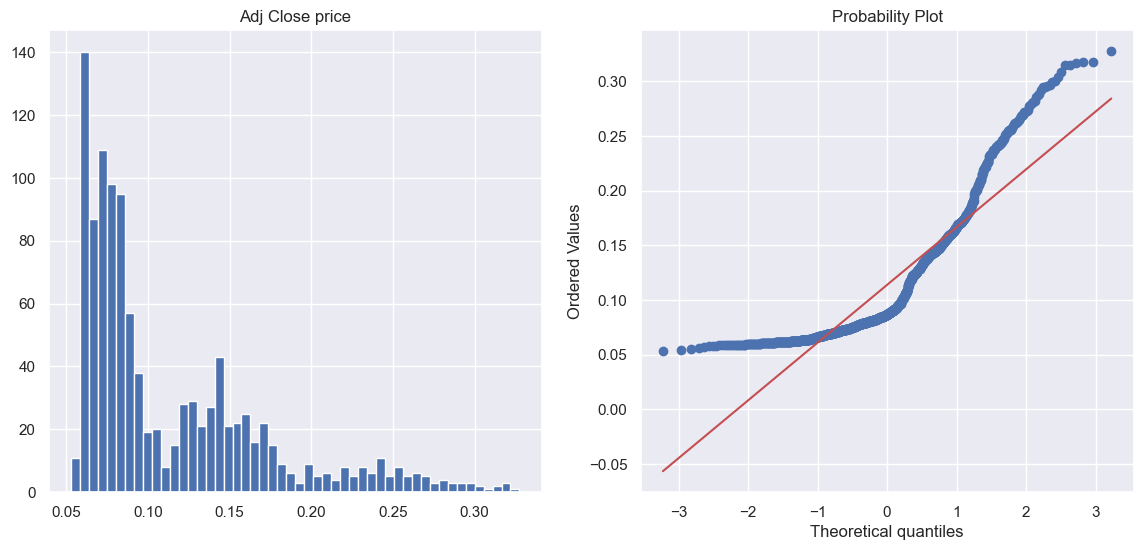

In [23]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
data['Adj Close'].hist(bins=50)
plt.title('Adj Close price')
plt.subplot(1,2,2)
stats.probplot(data['Adj Close'], plot=plt);
data['Adj Close'].describe().T

In [5]:
from statsmodels.tsa.stattools import adfuller

adfuller(data['returns'].dropna())

(np.float64(-5.894389876872524),
 np.float64(2.874212255594119e-07),
 0,
 3,
 {'1%': np.float64(-10.41719074074074),
  '5%': np.float64(-5.77838074074074),
  '10%': np.float64(-3.391681111111111)},
 np.float64(-22.872440827781247))

Series is stationary

In [25]:
data['smoothed_returns'] = data['returns'].rolling(window=3).mean().dropna()
data['state'] = data['returns'].apply(lambda x: 'up' if (x > 0.002)\
else ('down' if (x < -0.002)\
else 'no_change'))
data.tail()

,High,Low,Open,Adj Close,Volume,returns,smoothed_returns,state
Date,,,,,,,,
2024-08-17,0.103631,0.100156,0.100439,0.102755,305545333,0.022797,0.000649,up
2024-08-18,0.104306,0.100169,0.102755,0.100172,377630490,-0.025459,-0.000316,down
2024-08-19,0.101807,0.098712,0.100172,0.101504,463249309,0.013209,0.003516,up
2024-08-20,0.105619,0.101229,0.101506,0.103001,695089222,0.014640,0.000797,up
2024-08-22,0.106312,0.104286,0.106159,0.105292,521046976,0.021999,0.016616,up


In [26]:
data['prev_state'] = data['state'].shift(1)
data.tail()

,High,Low,Open,Adj Close,Volume,returns,smoothed_returns,state,prev_state
Date,,,,,,,,,
2024-08-17,0.103631,0.100156,0.100439,0.102755,305545333,0.022797,0.000649,up,no_change
2024-08-18,0.104306,0.100169,0.102755,0.100172,377630490,-0.025459,-0.000316,down,up
2024-08-19,0.101807,0.098712,0.100172,0.101504,463249309,0.013209,0.003516,up,down
2024-08-20,0.105619,0.101229,0.101506,0.103001,695089222,0.014640,0.000797,up,up
2024-08-22,0.106312,0.104286,0.106159,0.105292,521046976,0.021999,0.016616,up,up


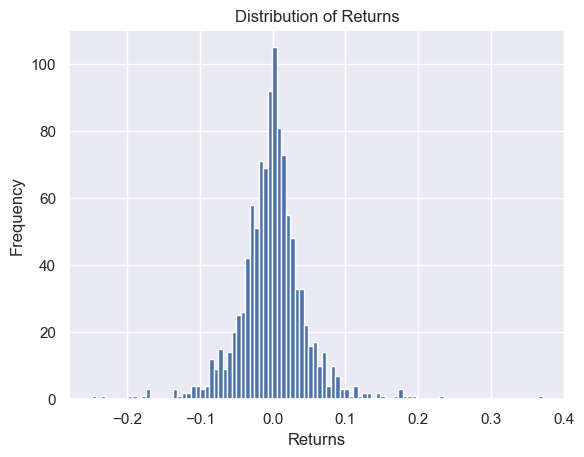

In [27]:
data['returns'].hist(bins=100)
plt.title('Distribution of Returns')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.show()

In [28]:
state_space = data[['prev_state', 'state']]
state_space_matrix = data.groupby(['prev_state', 'state']).size().unstack()
state_space_matrix

state,down,no_change,up
prev_state,,,
down,223,38,265
no_change,34,6,29
up,269,25,210


In [29]:
print(state_space_matrix.sum())

state
down         526
no_change     69
up           504
dtype: int64


In [30]:
transition_matrix = state_space_matrix.apply(lambda x: x/float(x.sum()), axis=1)
transition_matrix

state,down,no_change,up
prev_state,,,
down,0.423954,0.072243,0.503802
no_change,0.492754,0.086957,0.420290
up,0.533730,0.049603,0.416667


In [31]:
print(transition_matrix.sum(axis=1))

prev_state
down         1.0
no_change    1.0
up           1.0
dtype: float64


In [32]:
t0 = transition_matrix.copy()
t1 = round(t0.dot(t0), 4)
t1
t2 = round(t0.dot(t1), 4)
t2
t3 = round(t0.dot(t2), 4)
t3

state,down,no_change,up
prev_state,,,
down,0.4787,0.0628,0.4586
no_change,0.4786,0.0628,0.4587
up,0.4785,0.0628,0.4587


In [33]:
pd.DataFrame(np.linalg.matrix_power(t0,4))

<IPython.core.display.Javascript object>

,0,1,2
0,0.478677,0.062775,0.458549
1,0.478592,0.062789,0.458619
2,0.478558,0.062794,0.458648


In [34]:
# find the equilibrium matrix
i=1
a= t0.copy()
b = t0.dot(t0)
while(not(a.equals(b))):
  print('iteration number:' +str(i))
  i += 1
  a = b.copy()
  b = b.dot(t0)

iteration number:1
iteration number:2
iteration number:3
iteration number:4
iteration number:5
iteration number:6
iteration number:7
iteration number:8
iteration number:9
iteration number:10
iteration number:11
iteration number:12
iteration number:13
iteration number:14
iteration number:15
iteration number:16


In [35]:
from pprint import pprint 

# create a function that maps transition probability dataframe 
# to markov edges and weights

def _get_markov_edges(Q):
    edges = {}
    for col in Q.columns:
        for idx in Q.index:
            edges[(idx,col)] = Q.loc[idx,col]
    return edges

edges_wts = _get_markov_edges(transition_matrix)
pprint(edges_wts)
     

{('down', 'down'): np.float64(0.42395437262357416),
 ('down', 'no_change'): np.float64(0.07224334600760456),
 ('down', 'up'): np.float64(0.5038022813688213),
 ('no_change', 'down'): np.float64(0.4927536231884058),
 ('no_change', 'no_change'): np.float64(0.08695652173913043),
 ('no_change', 'up'): np.float64(0.42028985507246375),
 ('up', 'down'): np.float64(0.5337301587301587),
 ('up', 'no_change'): np.float64(0.0496031746031746),
 ('up', 'up'): np.float64(0.4166666666666667)}


Nodes:
['down', 'no_change', 'up']

Edges:


<IPython.core.display.Javascript object>

           0          1                                                  2
0       down       down  {'weight': 0.42395437262357416, 'label': 0.423...
1       down  no_change  {'weight': 0.07224334600760456, 'label': 0.072...
2       down         up  {'weight': 0.5038022813688213, 'label': 0.5038...
3  no_change       down  {'weight': 0.4927536231884058, 'label': 0.4927...
4  no_change  no_change  {'weight': 0.08695652173913043, 'label': 0.086...
5  no_change         up  {'weight': 0.42028985507246375, 'label': 0.420...
6         up       down  {'weight': 0.5337301587301587, 'label': 0.5337...
7         up  no_change  {'weight': 0.0496031746031746, 'label': 0.0496...
8         up         up  {'weight': 0.4166666666666667, 'label': 0.4166...
None


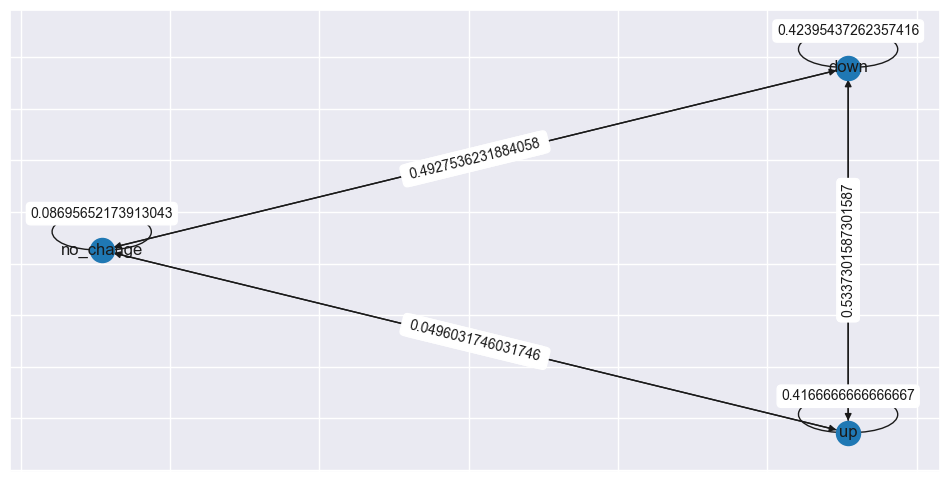

In [37]:
import networkx as nx
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'
states = ['up', 'down', 'no_change']

# create graph object
G = nx.MultiDiGraph()

# nodes correspond to states
G.add_nodes_from(state_space_matrix)
print(f'Nodes:\n{G.nodes()}\n')

# edges represent transition probabilities
for k, v in edges_wts.items():
    tmp_origin, tmp_destination = k[0], k[1]
    G.add_edge(tmp_origin, tmp_destination, weight=v, label=v)
print(f'Edges:')
pprint(pd.DataFrame(G.edges(data=True)))    

plt.figure(figsize=(12,6))
pos = nx.drawing.nx_pydot.graphviz_layout(G, prog='dot')
print(nx.draw_networkx(G, pos))

# create edge labels for jupyter plot but is not necessary
edge_labels = {(n1,n2):d['label'] for n1,n2,d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G , pos, edge_labels=edge_labels)
nx.drawing.nx_pydot.write_dot(G, 'nasdaq_markov.dot')

c:\Users\ashda\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                        Markov Switching Model Results                        
Dep. Variable:                returns   No. Observations:                 1098
Model:               MarkovRegression   Log Likelihood                1987.932
Date:                Thu, 22 Aug 2024   AIC                          -3951.865
Time:                        00:25:47   BIC                          -3891.850
Sample:                             0   HQIC                         -3929.159
                               - 1098                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0023      0.002     -1.417      0.156      -0.006       0.001
sigma2         0.0016      0.000     10.619      0.0

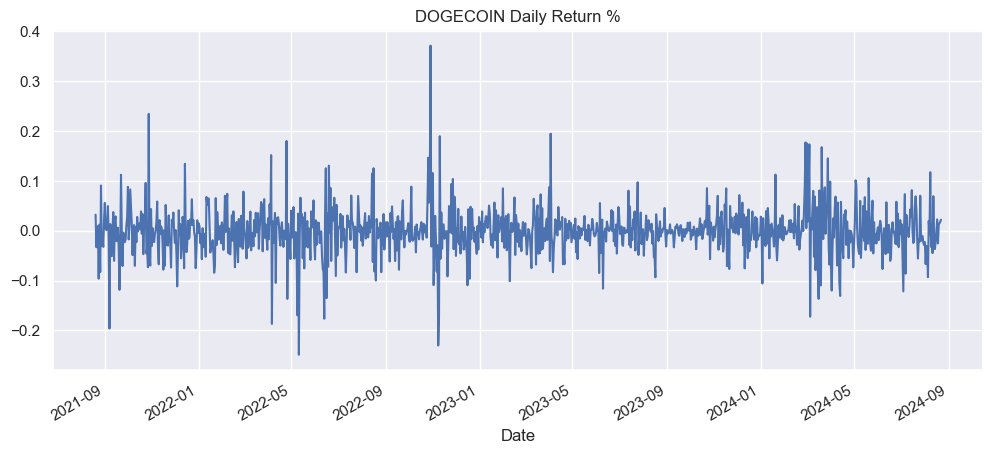

In [40]:
import statsmodels.api as sm

# Plot the data
data['returns'].plot(title='DOGECOIN Daily Return %', figsize=(12,5))

data.dropna(inplace=True)

model = sm.tsa.MarkovRegression(data['returns'][-2500:], k_regimes=3, switching_variance=True)


# launch the modelling process on the dataset
np.random.seed(274)
res_1 = model.fit(search_reps=50)

"""We specify that 50 random perturbations from the starting parameter 
vector are examined and the best one used as the actual starting parameters. 

Because of the random nature of the search, the random seed generator 
beforehand allow replication of the result"""

print(res_1.summary())

In [41]:
pred_1 = res_1.predict()
pred_1 = pd.DataFrame(pred_1).tail(20)
pred_1.rename(columns ={0: 'Predicted'}, inplace=True)
com_1 = pd.concat([pred_1, data['returns'].tail(20)], axis=1)
com_1 = com_1.reset_index()
com_1
     

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Date,Predicted,returns
0,2024-08-02,-0.002098,-0.067008
1,2024-08-03,-0.002070,-0.030402
2,2024-08-04,-0.001966,-0.041874
3,2024-08-05,-0.001759,-0.093189
4,2024-08-06,-0.001664,0.019574
5,2024-08-07,-0.001477,-0.008922
6,2024-08-08,-0.000947,0.117314
7,2024-08-09,-0.001650,-0.032457
8,2024-08-10,-0.001931,0.011741
9,2024-08-11,-0.002068,-0.045068


In [43]:
%pip install plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=com_1['Date'],y=com_1['returns'], name="Actual returns"))
fig.add_trace(go.Scatter(x=com_1['Date'],y=com_1['Predicted'], name="Predicted return"))
fig.update_layout(title="Nasdaq Actual vs Predicted returns", yaxis_title="Price ($)", font=dict(family="Courier New, monospace",size=18,color="#7f7f7f"))
fig.update_layout(autosize=False,width=800,height=400,)
fig.update_layout(legend_orientation="h")
fig.show()

^C
Note: you may need to restart the kernel to use updated packages.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed